Dataset: https://www.kaggle.com/jessemostipak/hotel-booking-demand/data

# Problem Framing

Our goal here is to identify whether a booking made by a customer will be cancelled or not. This classification will help in optimizing the room capacity. So if for example a customer is predicted to cancel their reservation, we can resell their room to another customer and therefore minimize the opportunity cost lost.

To do this, we will use Supervised Classification because we have a dataset defining which customers have cancelled (label) and from there we can train model to predict further data.

We will use F1-score as the main performance measure, which is a combination of Recall and Precision so that we can make sure that all the predicted cancel customers will actually cancel, and the model can predict all customers that will cancel.

The risks of wrong prediction will result in either opportunity cost lost if we incorrectly predicted that a customer will not cancel when they actually cancelled, or customer dissatisfaction when we predicted that a customer will cancel when in fact they did not cancel (so we don't have any room available for them, overbooking). This is a matter of Precision and Recall balance, and I think that it's best to prioritize Precision because a dissatisfied customer means they won't be coming back and they may give bad reviews which can damage our reputation in the long run. On the other hand, opportunity cost is a one-time cost that will not have any further damage to the company.

# EDA

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df_hotel = pd.read_csv('hotel_bookings.csv')

In [3]:
# get columns info
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

There are null values in children, country, agent, and company columns.

In [4]:
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


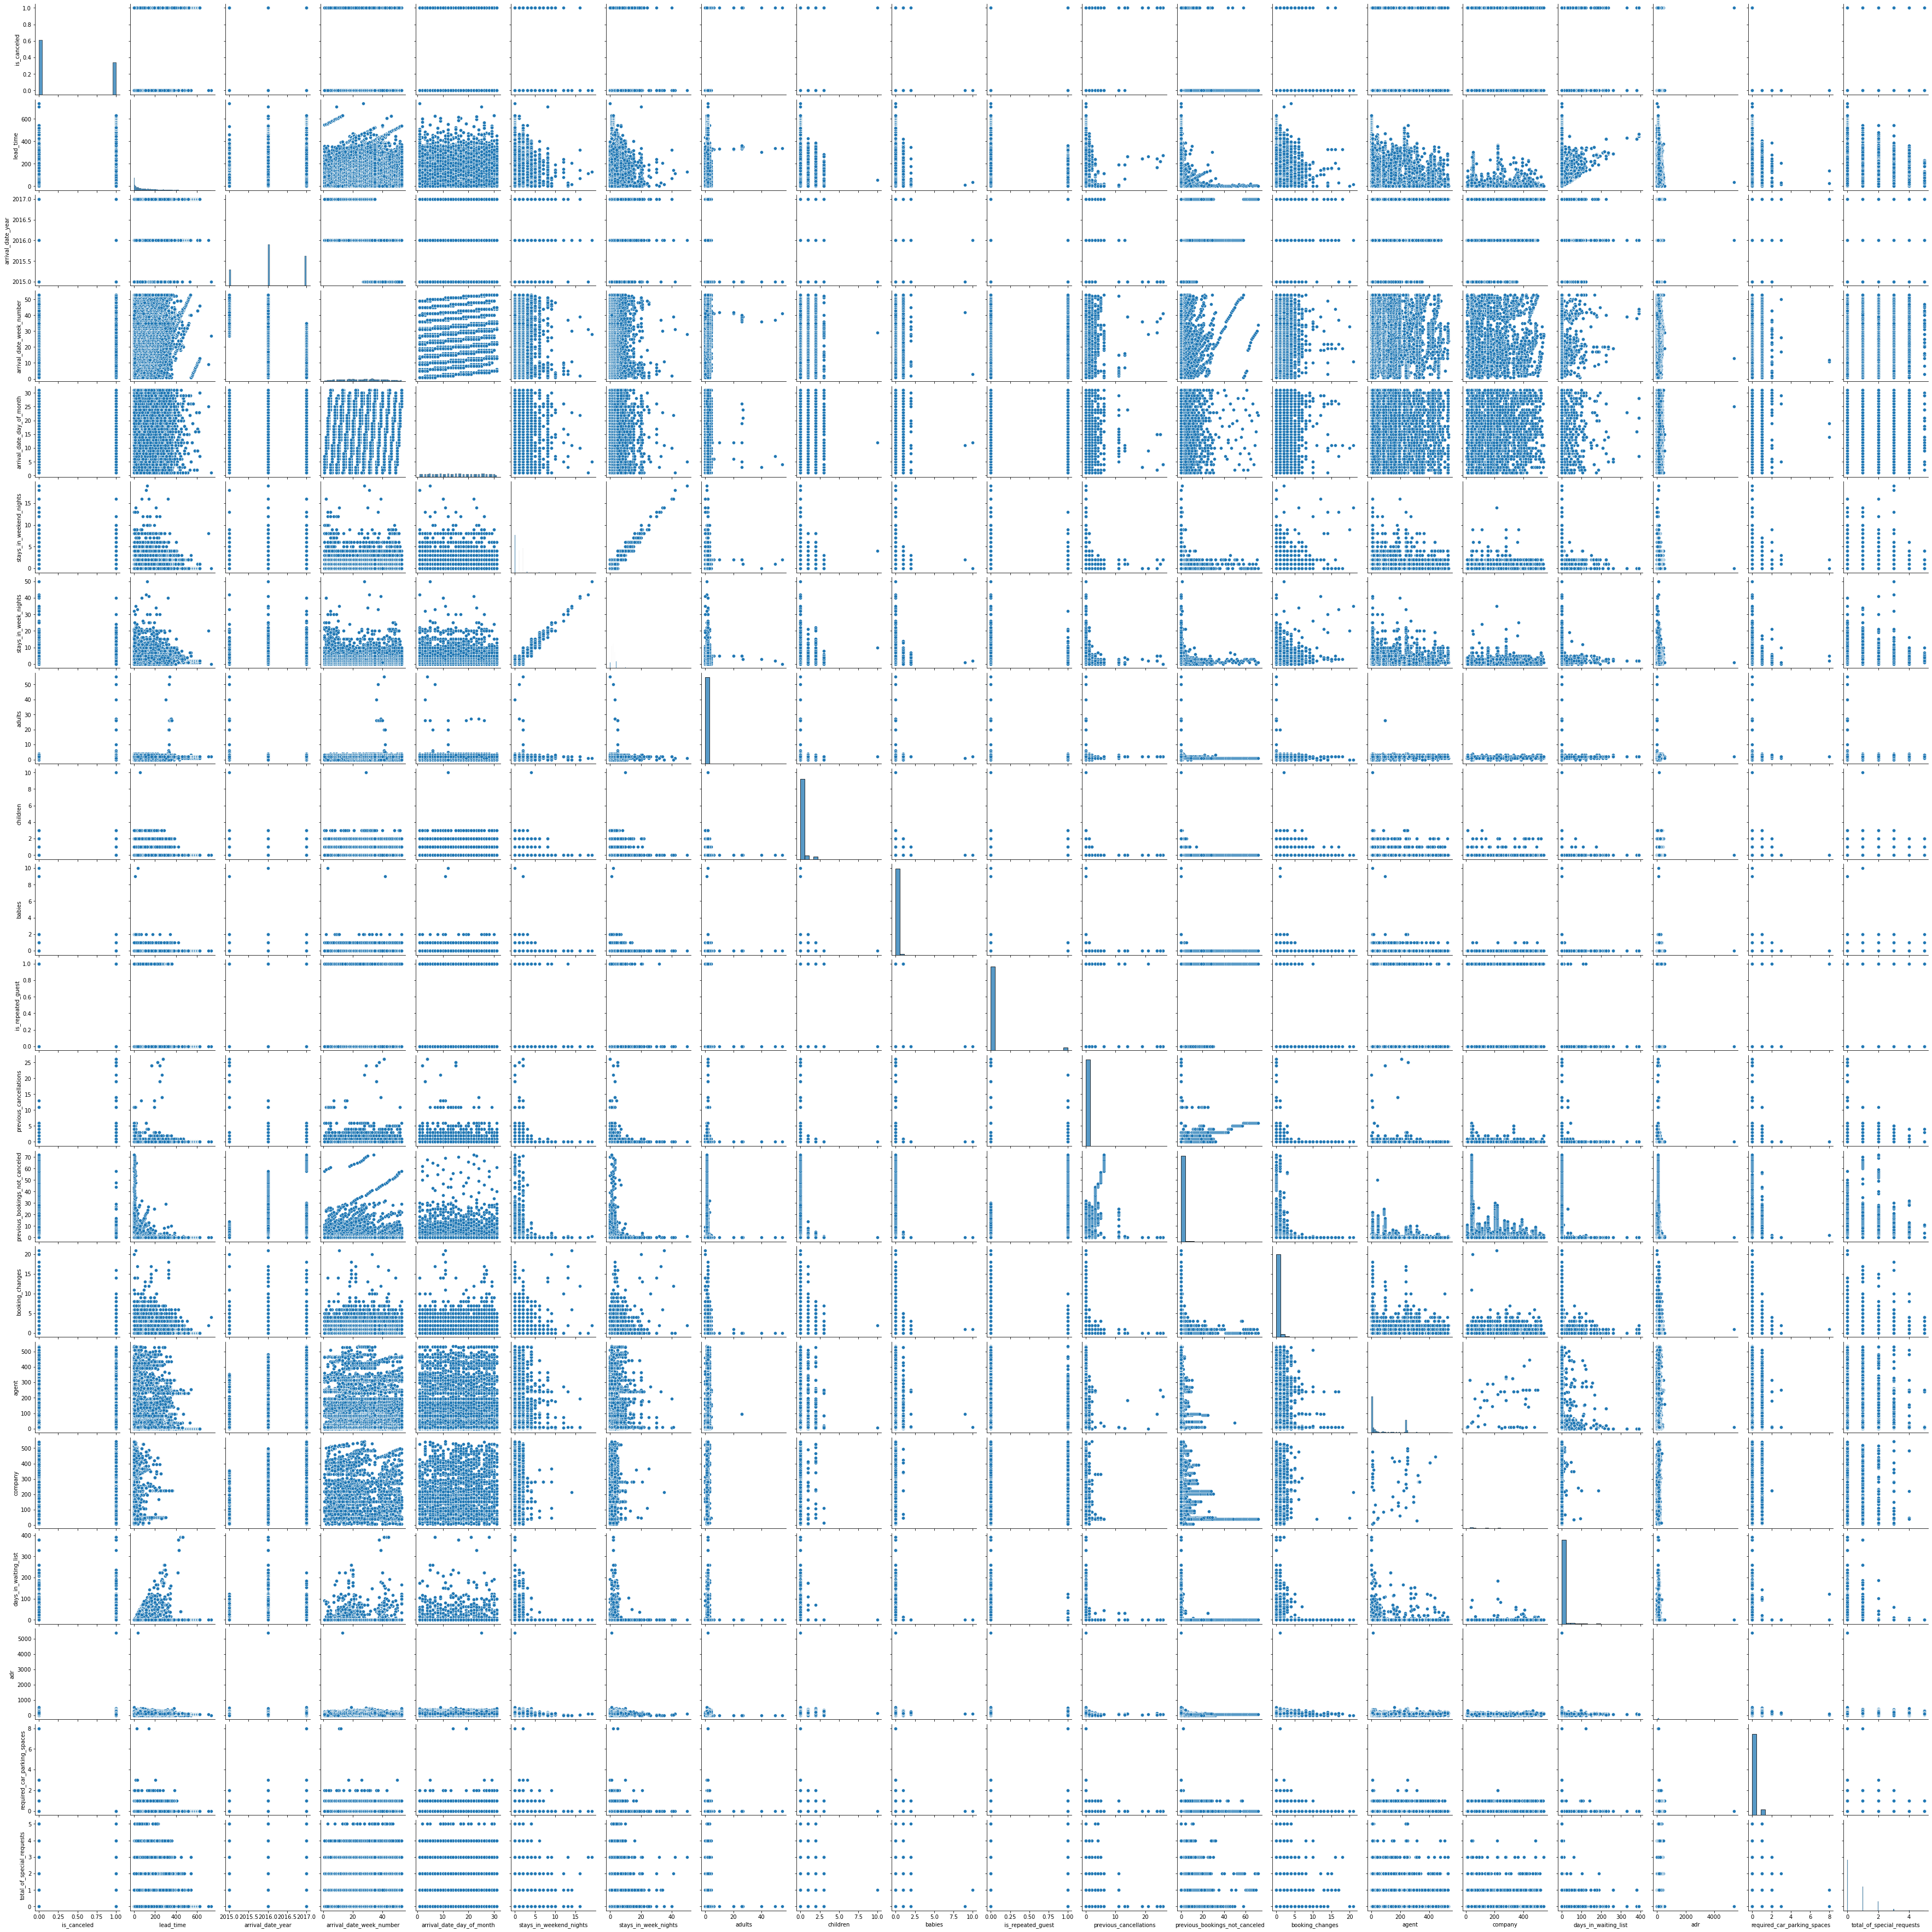

In [5]:
sns.pairplot(df_hotel);

At first glance, there is no correlation between variables except for arrival_date_week_number and arrival_date_day_of_month, so we will just use one of them to avoid multicollinearity.

In [6]:
df_hotel['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

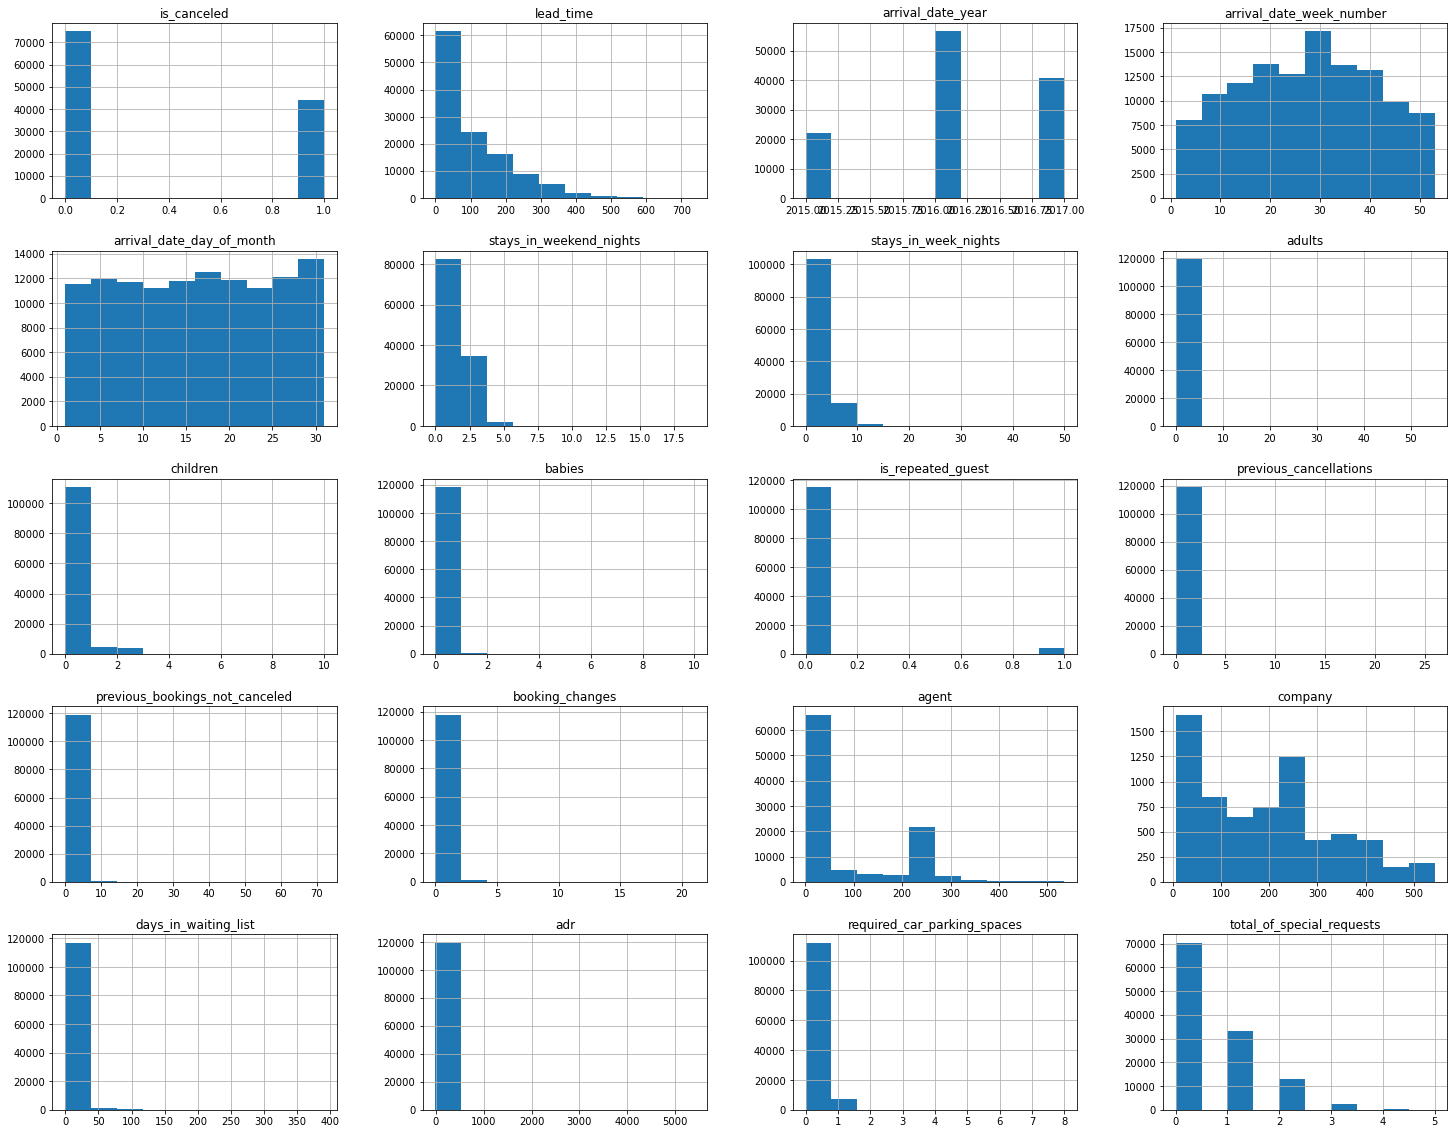

In [7]:
df_hotel.hist(figsize=(25,20));

In [8]:
df_hotel['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [9]:
ctg_cols = ['hotel', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type',
       'reservation_status']

num_cols = ['arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_date']

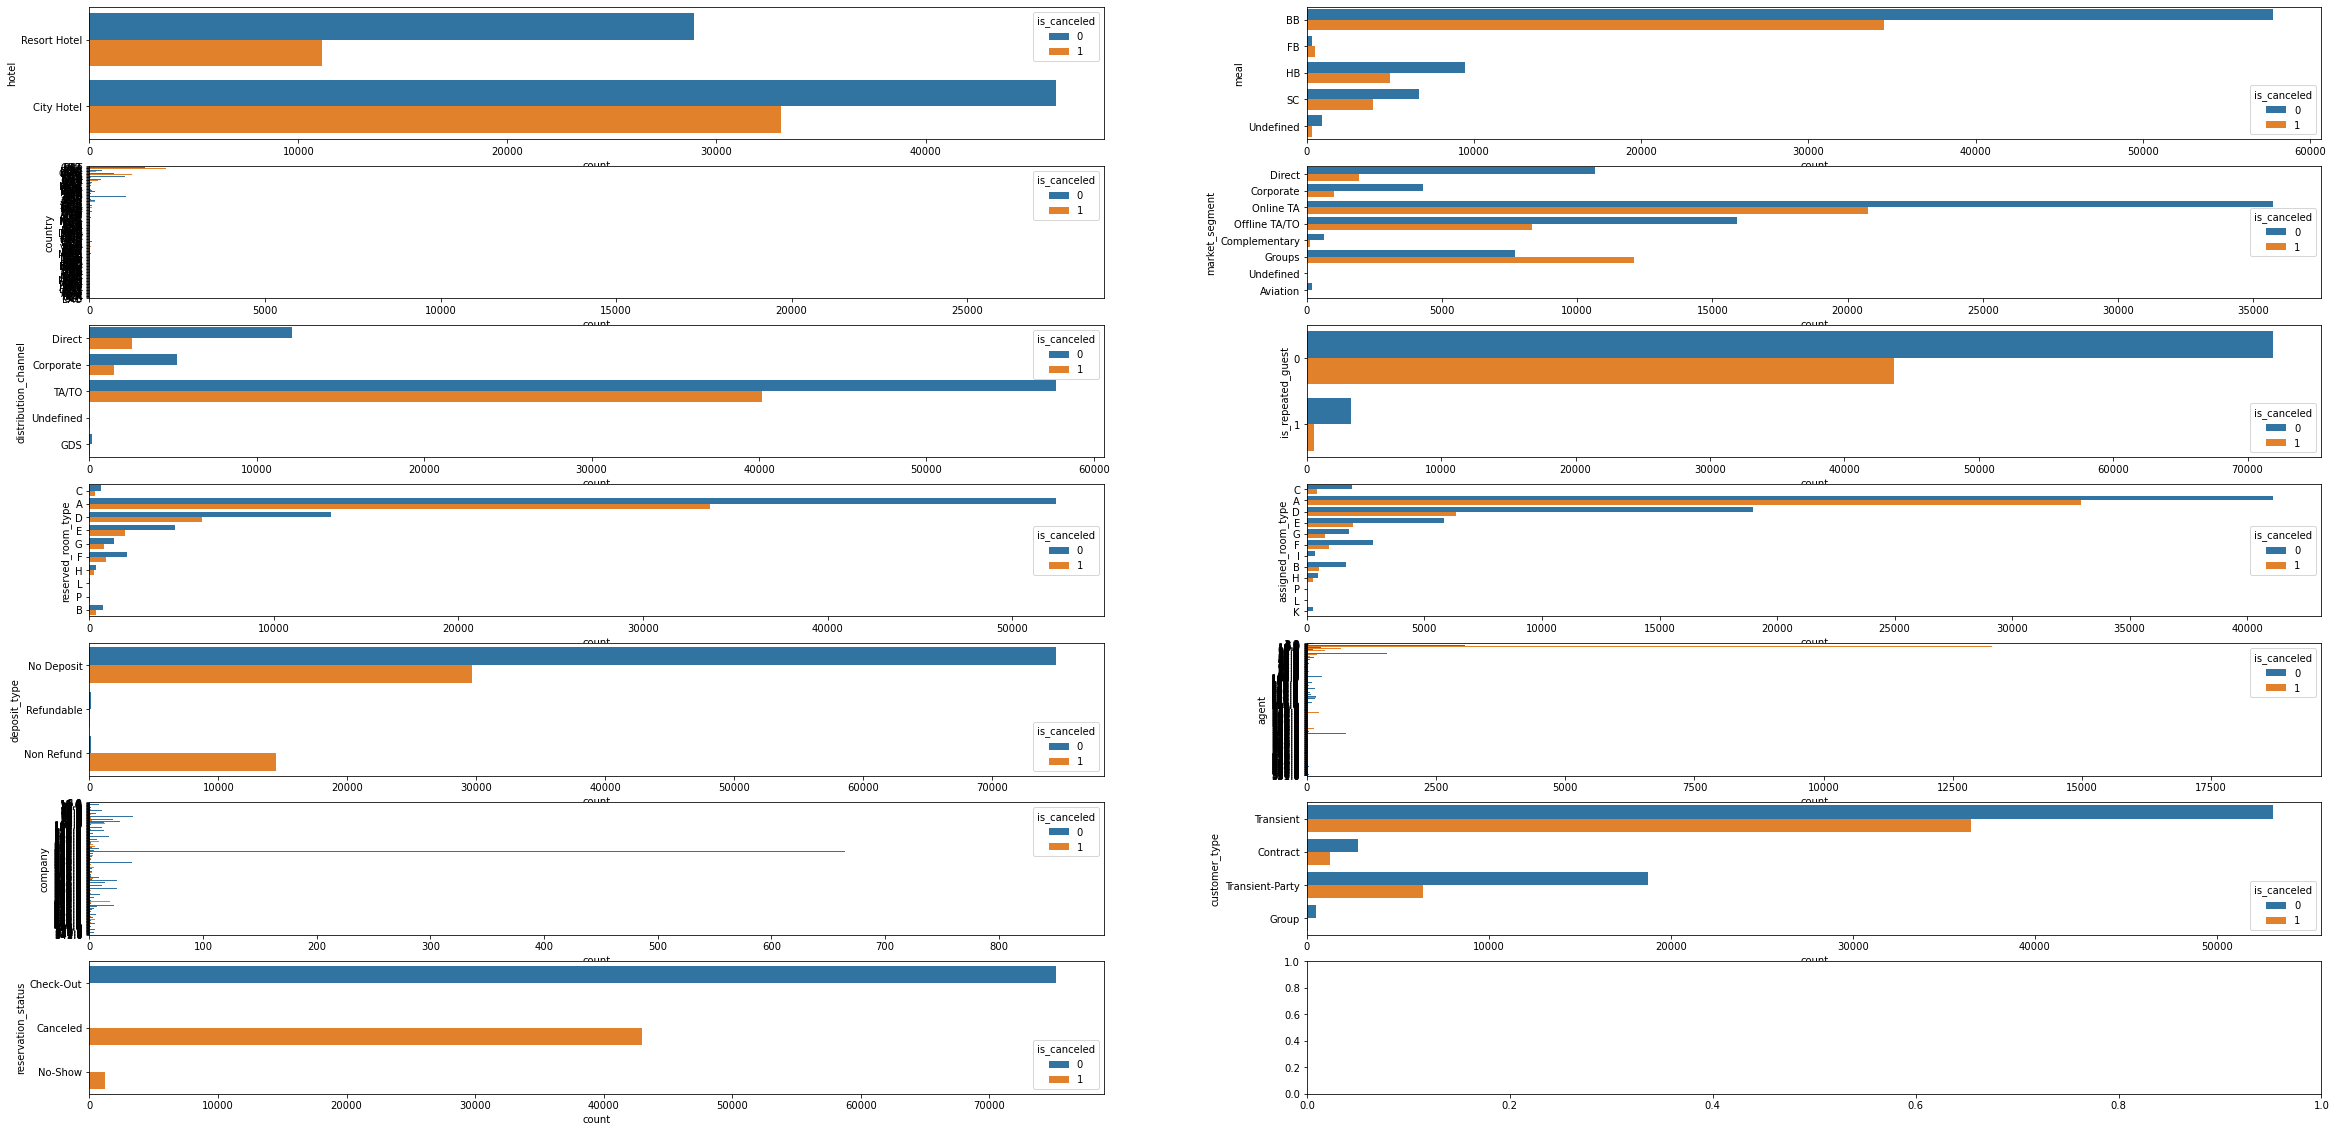

In [10]:
fig, axes = plt.subplots(7, 2, figsize=(40,20))
for ix, var in enumerate(ctg_cols):
    sns.countplot(y=var, hue='is_canceled', data=df_hotel, ax=axes.flatten()[ix])

# Data Preparation, Model Training, Evaluation, Selection

#### TODO Preprocessing:

drop:
- reservation_status
- reservation_status_date

impute null values:
- company (mode)
- country (mode)
- agent (mode)
- children (mean)

onehot encode:
- hotel
- market_segment
- distribution_channel
- reserved_room_type
- deposit_type
- customer_type

ordinal encode:
- arrival_date_month

In [11]:
# drop unnecessary columns
df_hotel.drop(['reservation_status', 'reservation_status_date'], axis=1, inplace=True)

In [12]:
# define X and y
label = ['is_canceled']

X = df_hotel.drop(label, axis=1)
y = df_hotel[label].values.flatten()

In [13]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

In [14]:
# make preprocessing column transformer

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

used_cols = ['hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number', 'stays_in_weekend_nights',
             'stays_in_week_nights', 'adults', 'children', 'market_segment', 'distribution_channel',
             'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'booking_changes',
             'deposit_type', 'days_in_waiting_list', 'customer_type', 'total_of_special_requests']

imputed_ctg_cols = ['company', 'agent']
imputed_num_cols = ['children']
onehot_cols = ['hotel', 'market_segment', 'reserved_room_type', 'deposit_type', 'customer_type']
ordinal_cols = ['arrival_date_month']
month_ordinal = [['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
skipped_cols = ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
                'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
                'days_in_waiting_list', 'total_of_special_requests']

class DoNothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values

preprocess_transformer = ColumnTransformer([
    ('ctg_imputer', SimpleImputer(strategy='most_frequent'), imputed_ctg_cols),
    ('num_imputer', SimpleImputer(strategy='mean'), imputed_num_cols),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal', OrdinalEncoder(categories=month_ordinal), ordinal_cols),
    ('skip', DoNothingTransformer(), skipped_cols)
])

In [15]:
# make model pipeline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline_log_reg = Pipeline([
    ('preprocess', preprocess_transformer),
    ('log_reg', LogisticRegression())
])

pipeline_dt = Pipeline([
    ('preprocess', preprocess_transformer),
    ('dt', DecisionTreeClassifier(random_state=10))
])

pipeline_knn = Pipeline([
    ('preprocess', preprocess_transformer),
    ('knn', KNeighborsClassifier())
])

In [16]:
# check the models' performance
for estimator in [pipeline_log_reg, pipeline_dt, pipeline_knn]:
    estimator.fit(X_train, y_train)
    y_test_pred = estimator.predict(X_test)
    print(estimator[-1].__class__.__name__)
    print('Train Accuracy: {:.3f}'.format(estimator.score(X_train, y_train)))
    print('Train Accuracy: {:.3f}'.format(estimator.score(X_test, y_test)))

C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
Accuracy: 0.792
DecisionTreeClassifier
Accuracy: 0.985
KNeighborsClassifier
Accuracy: 0.859


In [43]:
from sklearn.model_selection import cross_validate

cv_score_log_reg = pd.DataFrame(cross_validate(pipeline_log_reg, X_train, y_train, scoring=['accuracy', 'f1', 'recall', 'precision'],
               cv=5, return_train_score=True, return_estimator=True))

cv_score_dt = pd.DataFrame(cross_validate(pipeline_dt, X_train, y_train, scoring=['accuracy', 'f1', 'recall', 'precision'],
               cv=5, return_train_score=True, return_estimator=True))

C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [45]:
cv_score_log_reg

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.738238,0.054348,(ColumnTransformer(transformers=[('ctg_imputer...,0.790033,0.790875,0.680118,0.681598,0.602600,0.604282,0.780524,0.781601
1,0.712350,0.051815,(ColumnTransformer(transformers=[('ctg_imputer...,0.790033,0.788611,0.677079,0.674657,0.594262,0.591704,0.786717,0.784660
2,0.869223,0.046005,(ColumnTransformer(transformers=[('ctg_imputer...,0.796932,0.791467,0.682751,0.671220,0.589881,0.574674,0.810328,0.806756
3,0.776748,0.050849,(ColumnTransformer(transformers=[('ctg_imputer...,0.795205,0.793443,0.676961,0.676186,0.579282,0.582235,0.814263,0.806292
4,0.693057,0.057737,(ColumnTransformer(transformers=[('ctg_imputer...,0.788713,0.792828,0.661920,0.669685,0.558445,0.566952,0.812461,0.817890


In [46]:
cv_score_dt

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.787596,0.062440,(ColumnTransformer(transformers=[('ctg_imputer...,0.806365,0.986520,0.739379,0.981637,0.741521,0.972688,0.737249,0.990751
1,0.695603,0.052860,(ColumnTransformer(transformers=[('ctg_imputer...,0.807151,0.985970,0.741655,0.980889,0.747315,0.971982,0.736080,0.989960
2,0.676224,0.048928,(ColumnTransformer(transformers=[('ctg_imputer...,0.804890,0.985997,0.737146,0.980901,0.738553,0.970816,0.735745,0.991198
3,0.639334,0.049898,(ColumnTransformer(transformers=[('ctg_imputer...,0.809968,0.986376,0.742407,0.981451,0.739259,0.973077,0.745582,0.989971
4,0.690683,0.057151,(ColumnTransformer(transformers=[('ctg_imputer...,0.810910,0.986180,0.747130,0.981207,0.754205,0.973961,0.740186,0.988561


In [39]:
# check models' performance using multiple metrics

from sklearn.model_selection import cross_val_score

df_result = pd.DataFrame()

for regressor in [pipeline_log_reg, pipeline_dt, pipeline_knn]:
    df_result = df_result.append({
        'model': list(regressor.named_steps.keys())[-1],
        'accuracy': cross_val_score(regressor, X_train, y_train, cv=5, scoring='accuracy').mean(),
        'precision': cross_val_score(regressor, X_train, y_train, cv=5, scoring='precision').mean(),
        'recall': cross_val_score(regressor, X_train, y_train, cv=5, scoring='recall').mean(),
        'f1': cross_val_score(regressor, X_train, y_train, cv=5, scoring='f1').mean(),
    }, ignore_index=True)

C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sulis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [19]:
df_result

,model,accuracy,precision,recall,f1
0,log_reg,0.792236,0.801190,0.584640,0.675737
1,dt,0.807857,0.738968,0.744171,0.741543


Because the KNN model takes a long time to run, for the sake of time, we will not consider KNN as a potential model. Therefore, with the current results from Logistic Regression and Decision Tree, we are choosing Decision Tree because it has the higher F1-score, recall, and accuracy. 

# Hyperparameter Tuning

In [20]:
pipeline_dt

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ctg_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['company', 'agent']),
                                                 ('num_imputer',
                                                  SimpleImputer(),
                                                  ['children']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'market_segment',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('ordinal',
                                            

In [21]:
# using grid search to do hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [10, 15, 20, 25],
    'dt__min_samples_split': [2, 5],
    'dt__min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(pipeline_dt, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('ctg_imputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['company',
                                                                          'agent']),
                                                                        ('num_imputer',
                                                                         SimpleImputer(),
                                                                         ['children']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hotel',
          

In [22]:
pipeline_best = grid_search.best_estimator_
pipeline_best

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ctg_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['company', 'agent']),
                                                 ('num_imputer',
                                                  SimpleImputer(),
                                                  ['children']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'market_segment',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('ordinal',
                                            

#### Retrain model using tuned hyperparameter

In [23]:
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ctg_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['company', 'agent']),
                                                 ('num_imputer',
                                                  SimpleImputer(),
                                                  ['children']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'market_segment',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('ordinal',
                                            

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_train_pred = pipeline_best.predict(X_train)
y_test_pred = pipeline_best.predict(X_test)

y_train_pred_proba = pipeline_best.predict_proba(X_train)
y_test_pred_proba = pipeline_best.predict_proba(X_test)

# Accuracy
print('========\nTrain accuracy: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(accuracy_score(y_test, y_test_pred)))

# Precision (P) = TP / (TP + FP)
print('========\nTrain precision: {:.3f}'.format(precision_score(y_train, y_train_pred)))
print('Test precision: {:.3f}'.format(precision_score(y_test, y_test_pred)))


# Recall (P) = TP / (TP + FN)
print('========\nTrain recall: {:.3f}'.format(recall_score(y_train, y_train_pred)))
print('Test recall: {:.3f}'.format(recall_score(y_test, y_test_pred)))


# F1-score
print('========\nTrain F1-Score: {:.3f}'.format(f1_score(y_train, y_train_pred)))
print('Test F1-Score: {:.3f}'.format(f1_score(y_test, y_test_pred)))

Train accuracy: 0.886
Test accuracy: 0.830
Train precision: 0.901
Test precision: 0.812
Train recall: 0.777
Test recall: 0.705
Train F1-Score: 0.835
Test F1-Score: 0.755


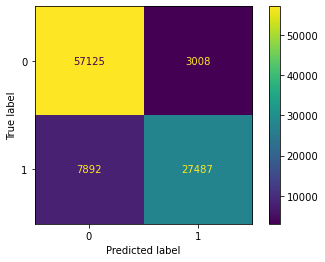

In [25]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline_best, X_train, y_train)

[Text(244.02014968444172, 212.26285714285714, 'X[24] <= 0.5\ngini = 0.466\nsamples = 95512\nvalue = [60133, 35379]'),
 Text(153.69046847029733, 201.90857142857143, 'X[31] <= 11.5\ngini = 0.406\nsamples = 83832\nvalue = [60050, 23782]'),
 Text(48.09289033233859, 191.5542857142857, 'X[31] <= 7.5\ngini = 0.197\nsamples = 19031\nvalue = [16928, 2103]'),
 Text(29.76077420594262, 181.2, 'X[3] <= 0.5\ngini = 0.168\nsamples = 15758\nvalue = [14301, 1457]'),
 Text(14.9122815039457, 170.84571428571428, 'X[31] <= 1.5\ngini = 0.118\nsamples = 7235\nvalue = [6781, 454]'),
 Text(7.7691028817699275, 160.49142857142857, 'X[0] <= 542.0\ngini = 0.091\nsamples = 3920\nvalue = [3732, 188]'),
 Text(7.706197155808163, 150.13714285714286, 'X[22] <= 0.5\ngini = 0.09\nsamples = 3918\nvalue = [3732, 186]'),
 Text(7.643291429846399, 139.78285714285715, 'X[9] <= 0.5\ngini = 0.09\nsamples = 3916\nvalue = [3732, 184]'),
 Text(5.095855253886984, 129.42857142857144, 'X[32] <= 17.5\ngini = 0.087\nsamples = 3895\nvalue

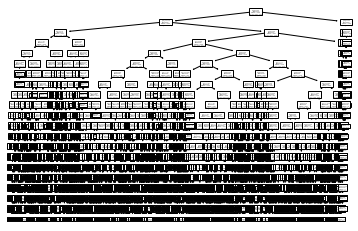

In [26]:
from sklearn import tree

tree.plot_tree(pipeline_best.named_steps['dt'])

# Result, Conclusion, and Recommendation

We were able to make a model that can predict whether a customer will cancel their booking with 83% accuracy, 81% precision, and 70% recall. This means that
- Out of all the predicted cancel customers, we have a 81% confidence that all of them will actually cancel, and
- We are confident that our prediction will cover 70% of all customers that will cancel.

From this prediction, we can make necessary adjustments on the number of rooms sold. When a customer book a room, we can run their information through this model and make a prediction whether they will cancel. If they are predicted to cancel, maybe we can resell their room to another customer so that there is no opportunity cost lost.

By using this model, we can also mitigate overbooking by only overselling when a customer is predicted to cancel, so there will be less dissatisfied customers.